# Health Prediction using Decision Trees and Random Forest
- by Chee-Foong
- on 21 Apr 2020

## Summary
The goal of this analysis is to predict an individual's health.  It is a binary classification problem that I solve using decision trees and random forest.  The analysis will first explore the building a decision tree on the data which will lead to a predicted class, how it will overfit on the training data and how random forest is a better alternative to limiting the depth of tree leading to bias-variance tradeoff and better performance

## Dataset
The dataset is contributed by the Centers for Disease Control and Prevention and can be downloaded [here](https://www.kaggle.com/cdc/behavioral-risk-factor-surveillance-system).

## Importing libraries

In [79]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import zipfile
import os

# Set random seed to ensure reproducible runs
seed = 50

In [129]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, accuracy_score, f1_score
from sklearn.metrics import precision_recall_curve

import itertools

In [ ]:
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import Image

In [194]:
datafolder = '../data/'
outputfolder = '../output/'

## Functions

In [161]:
## For model evaluation
def evaluate_model(test_predictions, test_probs, test_actual, train_predictions, train_probs, train_actual):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    
    results = {}
    
    baseline = {}
    
    test_baseline = [1 for _ in range(len(test_actual))]
    baseline['accuracy'] = accuracy_score(test_actual, test_baseline)
    baseline['recall'] = recall_score(test_actual, test_baseline)
    baseline['precision'] = precision_score(test_actual, test_baseline)
    baseline['f1'] = f1_score(test_actual, test_baseline)
    baseline['roc'] = 0.5
    
    test_results = {}
    
    test_results['accuracy'] = accuracy_score(test_actual, test_predictions)
    test_results['recall'] = recall_score(test_actual, test_predictions)
    test_results['precision'] = precision_score(test_actual, test_predictions)
    test_results['f1'] = f1_score(test_actual, test_predictions)
    test_results['roc'] = roc_auc_score(test_actual, test_probs)
    
    train_results = {}

    train_results['accuracy'] = accuracy_score(train_actual, train_predictions)
    train_results['recall'] = recall_score(train_actual, train_predictions)
    train_results['precision'] = precision_score(train_actual, train_predictions)
    train_results['f1'] = f1_score(train_actual, train_predictions)
    train_results['roc'] = roc_auc_score(train_actual, train_probs)
    
    results['baseline'] = baseline
    results['test'] = test_results
    results['train'] = train_results
    
    return pd.DataFrame(results).T


def plot_model(test_predictions, test_probs, test_actual, best='G'):
        
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_actual, [1 for _ in range(len(test_actual))])
    model_fpr, model_tpr, thresholds = roc_curve(test_actual, test_probs)

    # calculate the g-mean for each threshold
    gmeans = np.sqrt(model_tpr * (1-model_fpr))
    J = model_tpr - model_fpr

    if best == 'G':
        title = 'Best GMeans'
        # locate the index of the largest g-mean
        ix = np.argmax(gmeans)
        print('Best Threshold: {:.2f}'.format(thresholds[ix]))
        print('G-Mean: {:.2f}'.format(gmeans[ix]))

    else:
        title = "Best Youden's J Statistics"
        # Youden's J Statistics
        J = model_tpr - model_fpr

        # locate the index of the largest g-mean
        ix = np.argmax(J)
        print('Best Threshold: {:.2f}'.format(thresholds[ix]))
        print('J-stats: {:.2f}'.format(J[ix]))
        
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.scatter(model_fpr[ix], model_tpr[ix], marker='o', color='black', label='Best')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - ' + title)
    

def plot_model_pr(test_predictions, test_probs, test_actual, search=False):

    no_skill = len(test_y[test_y==1]) / len(test_y)
    
    if not search:
        # calculate pr-curve
        precision, recall, thresholds = precision_recall_curve(test_actual, test_probs)

        # convert to f score
        f1score = (2 * precision * recall) / (precision + recall)
        # locate the index of the largest f score
        ix = np.argmax(f1score)
        print('Best Threshold: {:.2f}'.format(thresholds[ix]))
        print('F1-Score: {:.2f}'.format(f1score[ix]))       

    else:
        # apply threshold to positive probabilities to create labels
        def to_labels(pos_probs, threshold):
            return (pos_probs >= threshold).astype('int')    

        # define thresholds
        thresholds = np.arange(0, 1, 0.001)

        # evaluate each threshold
        f1score = [f1_score(test_actual, to_labels(test_probs, t)) for t in thresholds]
        precision = [precision_score(test_actual, to_labels(test_probs, t)) for t in thresholds]
        recall = [recall_score(test_actual, to_labels(test_probs, t)) for t in thresholds]

        result = pd.DataFrame(list(zip(f1score, precision, recall)), columns=['f1','precision','recall'])
        result = result.loc[~(result==0).all(axis=1)]
        
        f1score = result.f1
        precision = result.precision
        recall = result.recall
        
        # get best threshold
        ix = np.argmax(np.array(f1score))
        print('Best Threshold: {:.2f}'.format(thresholds[ix]))
        print('F1-Score: {:.2f}'.format(f1score[ix]))       

    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16

    # Plot both curves
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='baseline')    
    plt.plot(recall, precision, 'r', label = 'model')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')   
    
        
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)

In [206]:
def plot_tree(tree, features_names, dot_path, png_path, max_depth, class_names):
    # Save tree as dot file
    export_graphviz(tree, dot_path, rounded = True, 
                    feature_names = features_names, max_depth = max_depth,
                    class_names = class_names, filled = True)

    # Convert to png
    call(['dot', '-Tpng', dot_path, '-o', png_path, '-Gdpi=200'])

## Data loading

In [3]:
file_list = []
dir_list = []
for root, dirs, files in os.walk(datafolder, topdown=False):
    for name in files:
        if (name != '.DS_Store'):
            file_list.append(os.path.join(datafolder, name))
    for name in dirs:
        dir_list.append(os.path.join(datafolder, name))

for file in file_list:
    if file.endswith('.zip'):
        zip_ref = zipfile.ZipFile(file, 'r')
        zip_ref.extractall(datafolder)
        zip_ref.close()
        os.remove(file)

In [4]:
file_list

['../data/2015_formats.json',
 '../data/2015.csv',
 '../data/2014.csv',
 '../data/2013.csv',
 '../data/2012.csv',
 '../data/2011.csv']

Only using 2015 for this analysis

In [20]:
train = pd.read_csv(datafolder + "2015.csv")

Only using numeric features

In [21]:
train = train.select_dtypes('number')

Using column **_RFHLTH** as the target label for individual' health condition, to set '2' to '0' and select observation with labels 0 and 1 only.
- 0 for poor health
- 1 for good health

In [22]:
with open(datafolder + "2015_formats.json") as f:
    metadata = json.load(f)

In [23]:
metadata['_RFHLTH']

{'.D': '"DK/NS"',
 '.R': '"REFUSED"',
 '1': '"Good or Better Health"',
 '2': '"Fair or Poor Health"',
 '9': '"Don\x92t know/Not Sure Or Refused/Missing"'}

In [24]:
train['_RFHLTH'] = train['_RFHLTH'].replace({2: 0})
train = train.loc[train['_RFHLTH'].isin([0, 1])].copy()
train = train.rename(columns = {'_RFHLTH': 'label'})
train['label'].value_counts()

1.0    358072
0.0     82137
Name: label, dtype: int64

Notice that it is an imbalanced dataset.  There are many more people in good health than in bad.

Removing columns with missing values

In [25]:
train = train.drop(columns = ['POORHLTH', 'PHYSHLTH', 'GENHLTH', 'PAINACT2', 
                        'QLMENTL2', 'QLSTRES2', 'QLHLTH2', 'HLTHPLN1', 'MENTHLTH'])

Creating the train test split with a ratio of 7:3 and stratifing the dataset because the target labels are imbalanced.

In [26]:
from sklearn.model_selection import train_test_split

# Extract the labels
labels = np.array(train.pop('label'))

# 30% examples in test data
train_X, test_X, train_y, test_y = train_test_split(train, labels, 
                                                          stratify = labels,
                                                          test_size = 0.3, 
                                                          random_state = seed)

Quick and dirty data cleansing by filling NAs with the mean in each column.

In [27]:
train_X = train_X.fillna(train_X.mean())
test_X = test_X.fillna(test_X.mean())

# Features for feature importances
features = list(train_X.columns)

In [28]:
train_X.shape

(308146, 313)

In [29]:
test_X.shape

(132063, 313)

## Building a Decision Tree

In [31]:
from sklearn.tree import DecisionTreeClassifier

# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=seed)

In [32]:
# Train tree
tree.fit(train_X, train_y)
print(f'Decision tree has {tree.tree_.node_count} nodes with maximum depth {tree.tree_.max_depth}.')

Decision tree has 54773 nodes with maximum depth 69.


In [33]:
# Make probability predictions
train_probs = tree.predict_proba(train_X)[:, 1]
test_probs = tree.predict_proba(test_X)[:, 1]

train_predictions = tree.predict(train_X)
test_predictions = tree.predict(test_X)

### Prediction Results
The AUC Score is 1 for the training dataset which means the model predicted all the training labels correctly.  This is expected because the model completely learn the training data and did not limit the depth of the tree.  In short, the model is overfitted.

In [89]:
print(f'Baseline ROC AUC Score: {roc_auc_score(test_y, [1 for _ in range(len(test_y))])}')
print(f'Train ROC AUC Score: {roc_auc_score(train_y, train_probs)}')
print(f'Test ROC AUC Score: {roc_auc_score(test_y, test_probs)}')

Baseline ROC AUC Score: 0.5
Train ROC AUC Score: 1.0
Test ROC AUC Score: 0.6765322577879385


In [90]:
# from collections import Counter
# print(Counter(test_probs))
# print(Counter(test_predictions))

The Geometric Mean or G-Mean is a metric for imbalanced classification that, if optimized, will seek a balance between the sensitivity and the specificity.

- G-Mean = sqrt(Sensitivity * Specificity)

In [91]:
evaluate_model(test_predictions, test_probs, test_y, train_predictions, train_probs, train_y)

accuracy        f1  precision    recall       roc
baseline  0.813415  0.897108   0.813415  1.000000  0.500000
test      0.798801  0.875736   0.879921  0.871591  0.676532
train     1.000000  1.000000   1.000000  1.000000  1.000000

Best Threshold: 1.00
G-Mean: 0.65


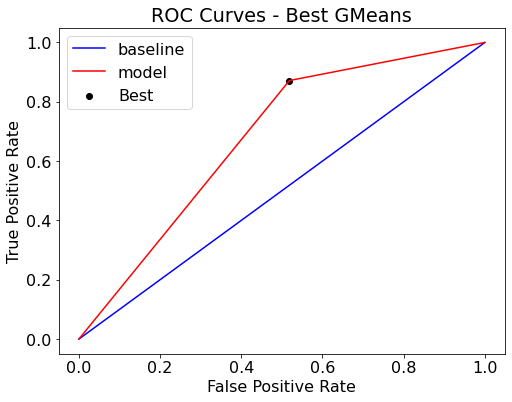

In [162]:
plot_model(test_predictions, test_probs, test_y)

Confusion matrix, without normalization


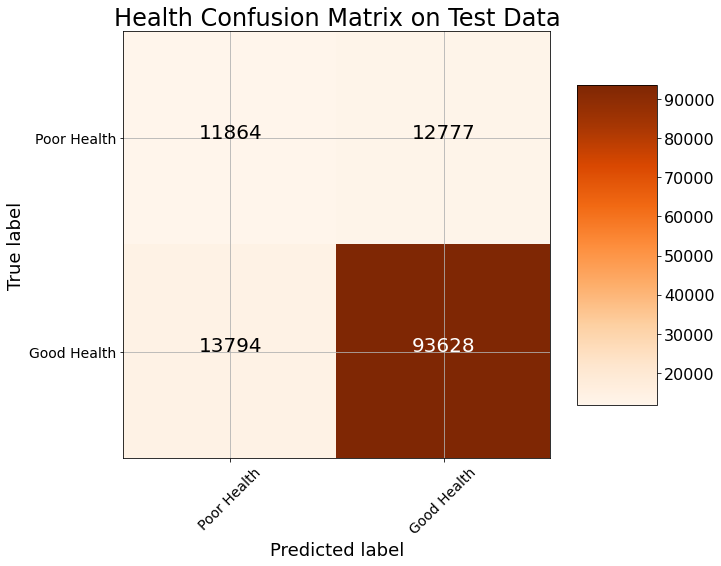

In [92]:
cm = confusion_matrix(test_y, test_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix on Test Data')

Importance Features as determined by the decision tree

In [94]:
impt_features = pd.DataFrame({'feature': features,
                   'importance': tree.feature_importances_}).\
                    sort_values('importance', ascending = False)
impt_features.head()

feature  importance
62   DIFFWALK    0.191466
58   QLACTLM2    0.031202
51    EMPLOY1    0.030919
245     _BMI5    0.016222
221   _LLCPWT    0.016014

Graphical Representation of the Decision Tree.  Limited to a depth of 6.

In [202]:
class_names = ['poor health', 'good health']
plot_tree(tree, outputfolder + 'tree_real_data.dot', outputfolder + 'tree_real_data.png', 6, class_names)
Image(filename=outputfolder + 'tree_real_data.png')

## Building Random Forest model
Training 100 decision trees with each tree on a slightly different set of observations and limited number of features.  The final predictions of the random forest are made by averaging the predictions of each tree.

In [99]:
from sklearn.ensemble import RandomForestClassifier

# Create the model with 100 trees
model = RandomForestClassifier(n_estimators=100, 
                               random_state=seed, 
                               max_features = 'sqrt',
                               n_jobs=-1, verbose = 1)

# Fit on training data
model.fit(train_X, train_y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [100]:
n_nodes = []
max_depths = []

for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 58450
Average maximum depth 56


In [101]:
train_rf_predictions = model.predict(train_X)
train_rf_probs = model.predict_proba(train_X)[:, 1]

rf_predictions = model.predict(test_X)
rf_probs = model.predict_proba(test_X)[:, 1]

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    6.4s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   12.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.5s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    2.8s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    5.9s finished


In [102]:
evaluate_model(rf_predictions, rf_probs, test_y, train_rf_predictions, train_rf_probs, train_y)

accuracy        f1  precision    recall       roc
baseline  0.813415  0.897108   0.813415  1.000000  0.500000
test      0.866412  0.920995   0.887384  0.957253  0.881987
train     0.999994  0.999996   0.999992  1.000000  1.000000

Note that the ROC for the Random Forest model of 0.88 is better than the Single Decision Tree of 0.67.  However, the Random Forest model may still have been overfitted as the ROC for the model on training data is 1.

The ROC plot shown below shows that the Random Forest model outperforms the Single Decision Tree model.

Best Threshold: 0.81
G-Mean: 0.79


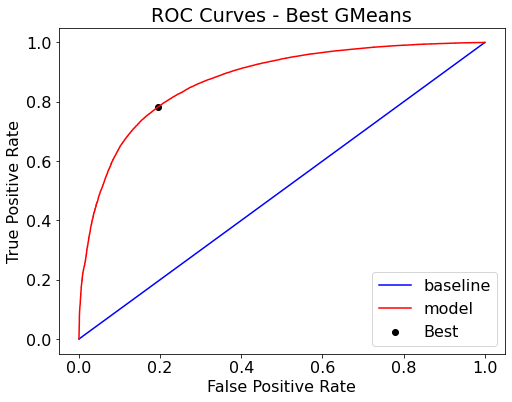

In [165]:
plot_model(rf_predictions, rf_probs, test_y, best='G')

Confusion matrix of Random Forest model also shows improvement.

Confusion matrix, without normalization


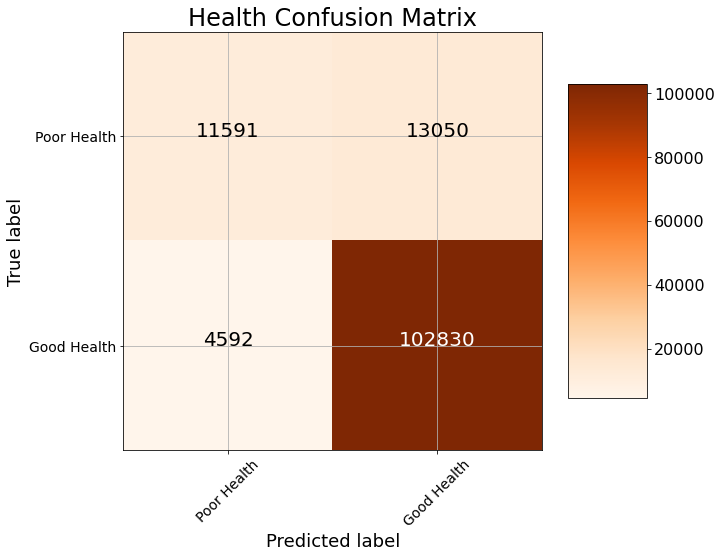

In [109]:
cm = confusion_matrix(test_y, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix on Test Data')

Important features as determined by Random Forest model

In [110]:
impt_features = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
impt_features.head(5)

feature  importance
62  DIFFWALK    0.041309
58  QLACTLM2    0.036630
51   EMPLOY1    0.024967
64  DIFFALON    0.022193
59  USEEQUIP    0.014600

## Building Random Forest model with hyperparameter grid search
Fine tuning Random Forest model by searching for the best parameter settings:
1. Number of decision trees
2. Maximum depth of each decision tree
3. Maximum number of features considered for splitting each node
4. Maximum number of data points required in a leaf node
5. Minimum number of samples required to split an internal node
6. Whether bootstrap samples are used when building trees

<span style='color:red'>**WARNING: This may take hours to run...**</span>

In [183]:
from sklearn.model_selection import RandomizedSearchCV

# Hyperparameter grid
param_grid = {
    'n_estimators': np.linspace(10, 200).astype(int),
    'max_depth': [None] + list(np.linspace(3, 20).astype(int)),
#     'max_features': ['auto', 'sqrt', None] + list(np.arange(0.5, 1, 0.1)),
    'max_features': ['auto', 'sqrt', None] + list(np.linspace(10, 25).astype(int)),
    'max_leaf_nodes': [None] + list(np.linspace(10, 50, 500).astype(int)),
    'min_samples_split': [2, 5, 10],
    'bootstrap': [True, False]
}

# Estimator for use in random search
estimator = RandomForestClassifier(random_state = seed)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, 
                        scoring = 'roc_auc', cv = 3, 
                        n_iter = 10, verbose = 1, random_state=seed)

# Fit 
rs.fit(train_X, train_y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 63.5min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

Show the best parameters to use for Random Forest

In [184]:
rs.best_params_

{'n_estimators': 126,
 'min_samples_split': 5,
 'max_leaf_nodes': 35,
 'max_features': 20,
 'max_depth': 7,
 'bootstrap': False}

Show the results of the best Random Forest model

In [185]:
best_model = rs.best_estimator_

In [186]:
train_rf_predictions = best_model.predict(train_X)
train_rf_probs = best_model.predict_proba(train_X)[:, 1]

rf_predictions = best_model.predict(test_X)
rf_probs = best_model.predict_proba(test_X)[:, 1]

In [187]:
max_depths = []

for ind_tree in best_model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 15076
Average maximum depth 7


In [188]:
evaluate_model(rf_predictions, rf_probs, test_y, train_rf_predictions, train_rf_probs, train_y)

accuracy        f1  precision    recall       roc
baseline  0.813415  0.897108   0.813415  1.000000  0.500000
test      0.856425  0.917085   0.864767  0.976141  0.874573
train     0.856068  0.916846   0.864842  0.975504  0.875710

Note that the optimal model although did not have a better F1 Score nor ROC, the scores are closed to the first Random Forest mode.  The average number of nodes and average maximum are much reduced without losing much performance.  

Best Threshold: 0.57
F1-Score: 0.92


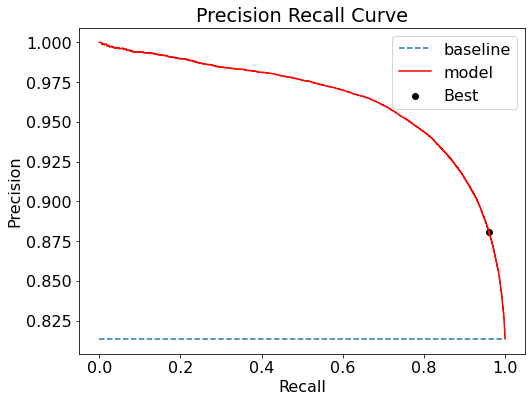

In [189]:
plot_model_pr(rf_predictions, rf_probs, test_y)

In [190]:
# plot_model_pr(rf_predictions, rf_probs, test_y, search=True)

Confusion matrix, without normalization


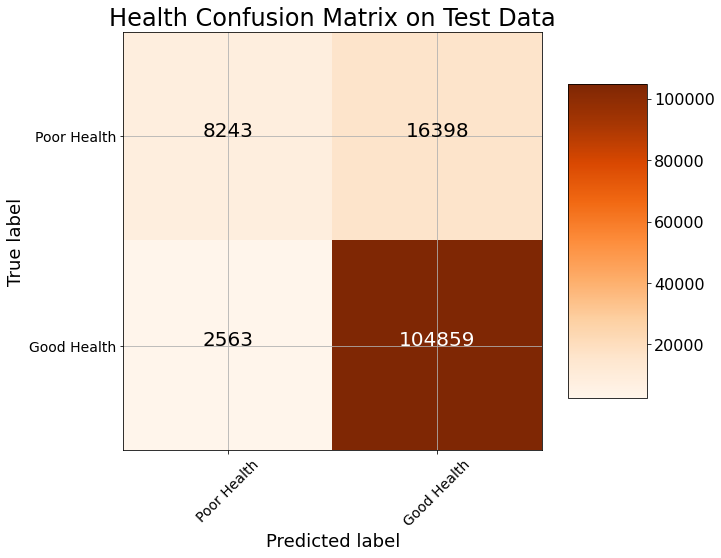

In [191]:
cm = confusion_matrix(test_y, rf_predictions)
plot_confusion_matrix(cm, classes = ['Poor Health', 'Good Health'],
                      title = 'Health Confusion Matrix on Test Data')

Show the best Random Forest tree

In [208]:
estimator = best_model.estimators_[1]
class_names = ['poor health', 'good health']

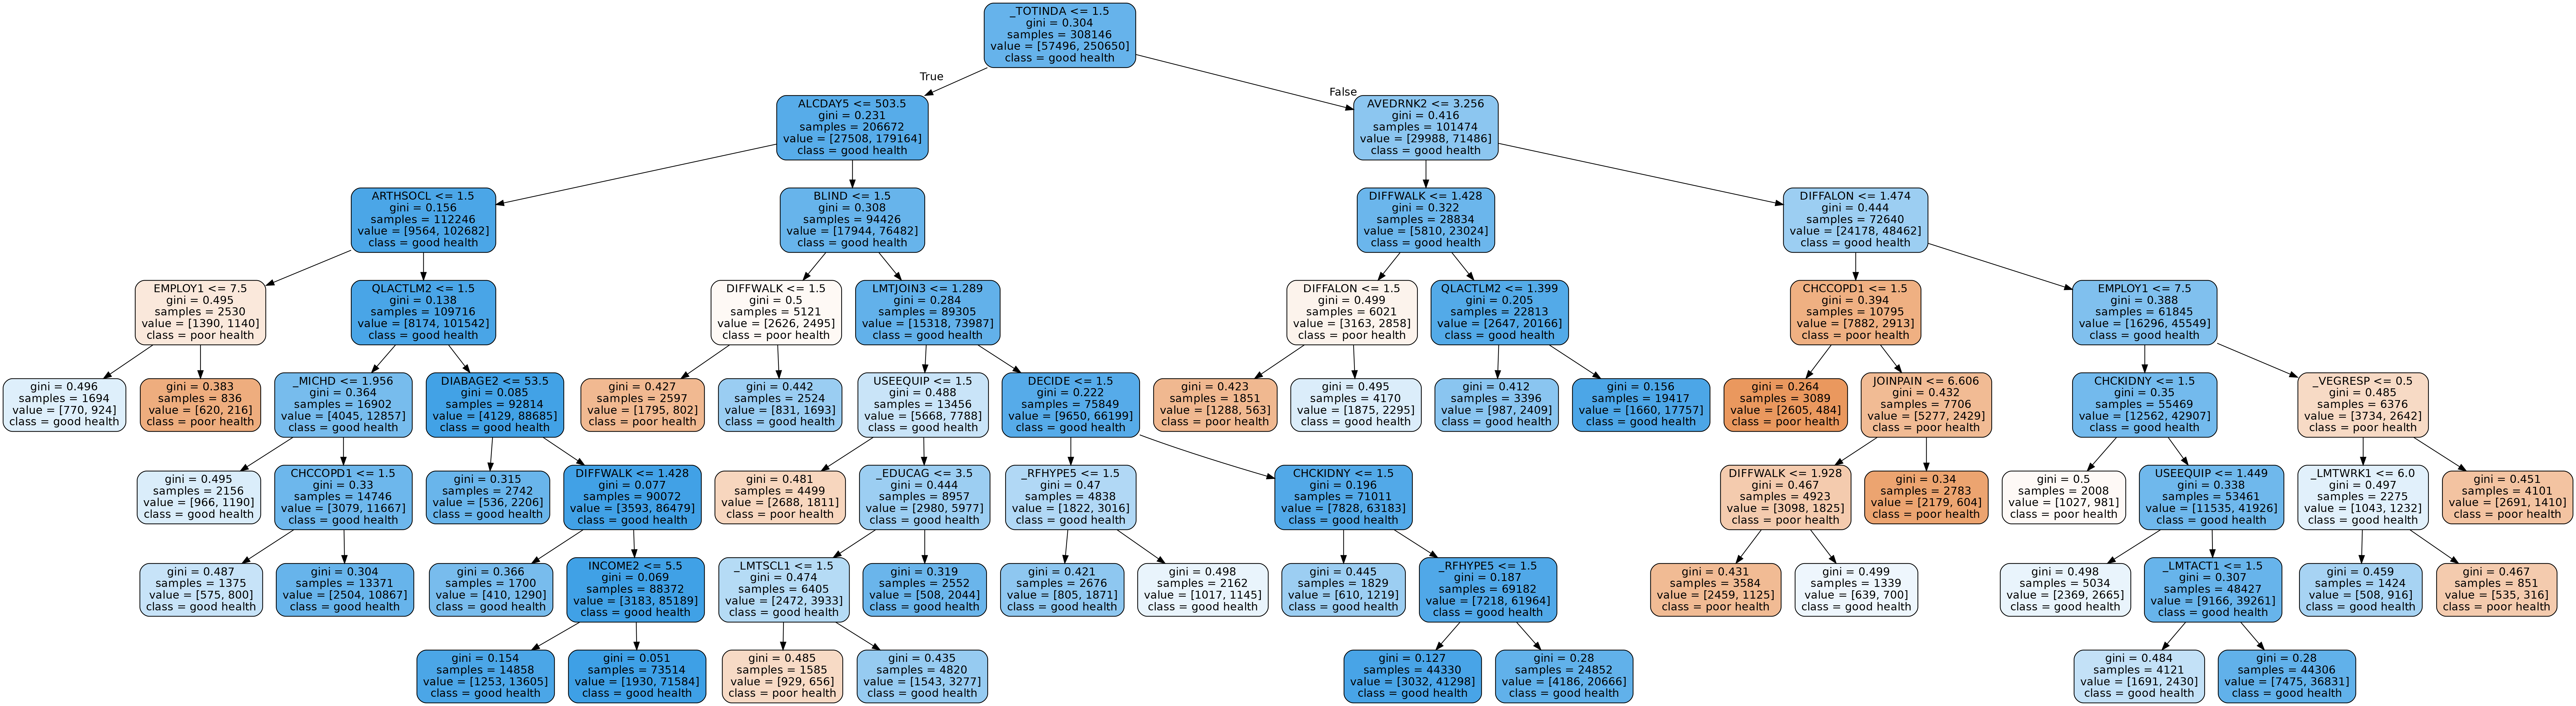

In [212]:
plot_tree(estimator, train.columns, outputfolder + 'tree_from_optimized_forest.dot',
          outputfolder + 'tree_from_optimized_forest.png', 8, class_names)
Image(filename=outputfolder + 'tree_from_optimized_forest.png')

## Conclusion
This analysis allowed me to developed an understanding of the Random Forest model that uses the concepts of random sampling of observations, random sampling of features and averaging predictions.

## References
1. https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76
2. https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb
3. https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/